In [13]:
from qiskit import __version__
print(__version__)

1.4.2


In [209]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.library import HGate, UnitaryGate

In [210]:
# Create a UnitaryGate with Hadamard matrix but custom label
H_matrix = HGate().to_matrix()
h_tagged = UnitaryGate(H_matrix, label='s_hadamard')

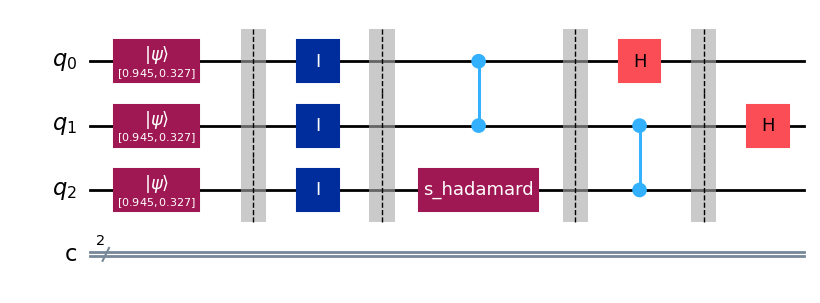

In [211]:
circuit = QuantumCircuit(3, 2)

# State prep
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

for i in range(3):
    circuit.initialize([amp_0, amp_1], i)
circuit.barrier()

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.append(h_tagged, [2])
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.cz(1,2)
circuit.barrier()

# Measure qubit 1 in X basis, and insert error on qubit 2
circuit.h(1)

display(circuit.draw(output='mpl'))

# Results without Noise

In [213]:
state_before_measurement = Statevector.from_instruction(circuit)
display(state_before_measurement.draw("latex"))

res, collapsed = state_before_measurement.measure([0, 1])
print("Measured: ", res)
display(collapsed.draw("latex"))

<IPython.core.display.Latex object>

Measured:  00


<IPython.core.display.Latex object>

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='14e208be-4b1d-4f5d-8281-3f8ebfca7251', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 203, '0x3': 67, '0x2': 289, '0x0': 441}, state_post=[{'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x2': (0.8260616185755724+0j), '0x6': (0.5635798100680199+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x1': (0.9966805530440662+0j), '0x5': (0.0814117631781459+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x2': (0.8260616185755724+0j), '0x6': (0.5635798100680199+0j)}, {'0x0': (0.945026819131982+0j), 

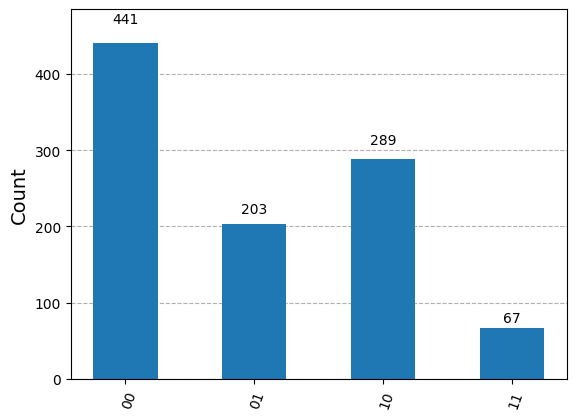

In [214]:
meas_circuit = circuit.copy()
meas_circuit.measure([0, 1], [0, 1])

meas_circuit.save_statevector_dict(label='state_post', pershot=True)

backend = AerSimulator(method='statevector')

transpiled = transpile(meas_circuit, backend)

job = backend.run(transpiled, shots=1000)
result = job.result()
print(result)

counts = result.get_counts()
display(plot_histogram(counts)) 


In [215]:
res_statevectors = result.data()['state_post']
print(res_statevectors)

correct = 0
incorrect = 0

target_key  = '0x0'
target_amp  = (0.945026819131982+0j)
for shot in res_statevectors:
    if target_key in shot and target_amp == shot[target_key]:
        correct += 1
    else:
        incorrect += 1
    
print(f"Number of correct outputs measuring '00': {correct}")
print(f"Number of incorrect outputs regardless of measurement: {incorrect}")

[{'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x2': (0.8260616185755724+0j), '0x6': (0.5635798100680199+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x1': (0.9966805530440662+0j), '0x5': (0.0814117631781459+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x2': (0.8260616185755724+0j), '0x6': (0.5635798100680199+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x1': (0.9966805530440662+0j), '0x5': (0.0814117631781459+0j)}, {'0x0': (0.945026819131982+0j), '0x4': (0.32699283038208704+0j)}, {'0x3': (0.32699283038208676+0j), '0x7': (0.945026819131982+0j)}, {'0x2': (0.8260616185755724+0j), '0x6': (0.5635798100680199+0j)}, {'0x0': (

# Results with Noise

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='f27a8806-972b-4b4e-a763-7afff304ed0f', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 202, '0x0': 434, '0x3': 75, '0x2': 289}, state_post={'0x1': [Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([-0.00000000e+00+0.j        ,  9.96855810e-16-0.94502682j,
             

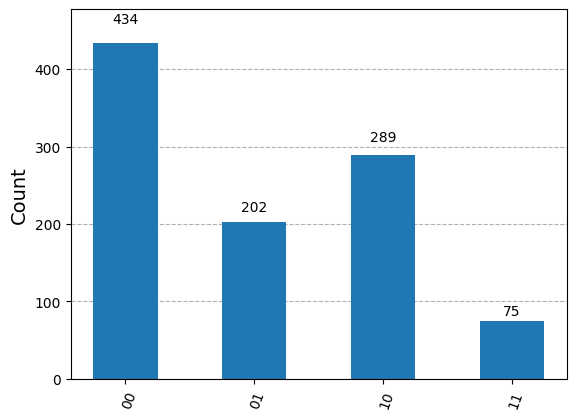

In [226]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['s_hadamard'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2),['cz'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [0])
noise_model.add_readout_error(readout_err, [1])

meas_circuit_noise = circuit.copy()
meas_circuit_noise.measure([0, 1], [0, 1])

meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

backend = AerSimulator(noise_model=noise_model)

transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)

job = backend.run(transpiled,shots=1000)
result = job.result()
print(result)

counts_noise = result.get_counts()
display(plot_histogram(counts_noise)) 

In [227]:
res_statevectors = result.data()['state_post']
print(res_statevectors)

target_amplitudes = Statevector([
    0.94502682+1.41221240e-15j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.32699283+5.19195734e-16j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2))

correct = 0
for value in res_statevectors['0x0']:
    if target_amplitudes == value:
        correct += 1

print(f"Number of correct outputs measuring '00': {correct}")

{'0x1': [Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([-0.00000000e+00+0.j        ,  9.96855810e-16-0.94502682j,
             -0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
             -0.00000000e+00+0.j        ,  3.73820929e-16-0.32699283j,
             -0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
            dims=(2, 2, 2)), Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-1

# Fidelity Calculations

In [230]:
# Calculating the average state of all 00 measurement outcomes
num_meas = len(res_statevectors['0x0'])
zero_array = np.zeros((2**3, 2**3), dtype=complex)
average = DensityMatrix(zero_array)
for shot in res_statevectors['0x0']:
    temp_dm = DensityMatrix(shot)
    average = average + temp_dm
average = average / num_meas

ideal = Statevector([0.94502682+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.32699283+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))
#display(ideal.draw("latex"))

fidelity = state_fidelity(ideal, average)
print(fidelity)

0.9596238915067415
